In [1]:
#!/usr/bin/env python
"""
 @file   baseline.py
 @brief  Baseline code of simple AE-based anomaly detection used experiment in [1].
 @author Ryo Tanabe and Yohei Kawaguchi (Hitachi Ltd.)
 Copyright (C) 2019 Hitachi, Ltd. All right reserved.
 [1] Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.
"""
########################################################################
# import default python-library
########################################################################
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy
import librosa
import librosa.core
import librosa.feature
import yaml
# from import
from tqdm import tqdm
from sklearn import metrics

import torch
import torch.nn as nn

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from utils import *
from model import TorchConvModel
########################################################################


########################################################################
# version
########################################################################
__versions__ = "1.0.3"
########################################################################



########################################################################
# feature extractor
########################################################################

def list_to_spec_vector_2d_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.
    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.
    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """

    # 02 loop of file_to_vectorarray
    for idx in tqdm(range(len(file_list)), desc=msg):

        vector_array = file_to_spec_vector_2d_array(file_list[idx],
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), frames, n_mels), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :, :] = vector_array

    return dataset


class AEDataset(torch.utils.data.Dataset):
    def __init__(self, 
            file_list,
            param,
            target_source=None,
            ):
        self.file_list = file_list
        self.target_source = target_source

        self.data_vector = list_to_spec_vector_2d_array(self.file_list,
                                            msg="generate train_dataset",
                                            n_mels=param["feature"]["n_mels"],
                                            frames=param["feature"]["frames"],
                                            n_fft=param["feature"]["n_fft"],
                                            hop_length=param["feature"]["hop_length"],
                                            power=param["feature"]["power"],
                                            )
        
    
    def __getitem__(self, index):
        return torch.Tensor(self.data_vector[index, :, :])
    
    def __len__(self):
        return self.data_vector.shape[0]


def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):
    """
    target_dir : str
        base directory path of the dataset
    normal_dir_name : str (default="normal")
        directory name the normal data located in
    abnormal_dir_name : str (default="abnormal")
        directory name the abnormal data located in
    ext : str (default="wav")
        filename extension of audio files 
    return : 
        train_data : numpy.array( numpy.array( float ) )
            training dataset
            * dataset.shape = (total_dataset_size, feature_vector_length)
        train_files : list [ str ]
            file list for training
        train_labels : list [ boolean ] 
            label info. list for training
            * normal/abnormal = 0/1
        eval_files : list [ str ]
            file list for evaluation
        eval_labels : list [ boolean ] 
            label info. list for evaluation
            * normal/abnormal = 0/1
    """
    logger.info("target_dir : {}".format(target_dir))

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext))))
    normal_labels = numpy.zeros(len(normal_files))
    if len(normal_files) == 0:
        logger.exception("no_wav_data!!")

    # 02 abnormal list generate
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))                              
    abnormal_labels = numpy.ones(len(abnormal_files))
    if len(abnormal_files) == 0:
        logger.exception("no_wav_data!!")

    # 03 separate train & eval
    train_files = normal_files[len(abnormal_files):]
    train_labels = normal_labels[len(abnormal_files):]
    eval_files = numpy.concatenate((normal_files[:len(abnormal_files)], abnormal_files), axis=0)
    eval_labels = numpy.concatenate((normal_labels[:len(abnormal_files)], abnormal_labels), axis=0)
    logger.info("train_file num : {num}".format(num=len(train_files)))
    logger.info("eval_file  num : {num}".format(num=len(eval_files)))

    return train_files, train_labels, eval_files, eval_labels


########################################################################

class ReconOutputTarget:
    def __init__(self, model_input):
        self.model_input = model_input
        self.error_func = nn.MSELoss(reduction='mean')
    def __call__(self, model_output):
        assert self.model_input.shape == model_output.shape
        error = self.error_func(self.model_input, model_output)
        return error


########################################################################
# main
########################################################################

########################################################################

In [2]:

# load parameter yaml
with open("baseline.yaml") as stream:
    param = yaml.safe_load(stream)

param["feature"]["frames"] = 21


# make output directory
os.makedirs(param["pickle_directory"], exist_ok=True)
os.makedirs(param["model_directory"], exist_ok=True)
os.makedirs(param["result_directory"], exist_ok=True)

# setup the result
result_file = "{result}/{file_name}".format(result=param["result_directory"], file_name=param["result_file"])
results = {}

target_dir = "{base}/6dB/valve/id_00".format(base=param["base_directory"])
print("\n===========================")
print("[{num}/{total}] {dirname}".format(dirname=target_dir, num=1, total=1))

# dataset param        
db = os.path.split(os.path.split(os.path.split(target_dir)[0])[0])[1]
machine_type = os.path.split(os.path.split(target_dir)[0])[1]
machine_id = os.path.split(target_dir)[1]

# setup path
evaluation_result = {}
train_pickle = "{pickle}/bgc_train_{machine_type}_{machine_id}_{db}.pickle".format(pickle=param["pickle_directory"],
                                                                               machine_type=machine_type,
                                                                               machine_id=machine_id, db=db)
eval_files_pickle = "{pickle}/bgc_eval_files_{machine_type}_{machine_id}_{db}.pickle".format(
                                                                               pickle=param["pickle_directory"],
                                                                               machine_type=machine_type,
                                                                               machine_id=machine_id,
                                                                               db=db)
eval_labels_pickle = "{pickle}/ebgc_val_labels_{machine_type}_{machine_id}_{db}.pickle".format(
                                                                               pickle=param["pickle_directory"],
                                                                               machine_type=machine_type,
                                                                               machine_id=machine_id,
                                                                               db=db)
model_file = "{model}/bgc_model_{machine_type}_{machine_id}_{db}.hdf5".format(model=param["model_directory"],
                                                                          machine_type=machine_type,
                                                                          machine_id=machine_id,
                                                                          db=db)
history_img = "{model}/bgc_history_{machine_type}_{machine_id}_{db}.png".format(model=param["model_directory"],
                                                                            machine_type=machine_type,
                                                                            machine_id=machine_id,
                                                                            db=db)
evaluation_result_key = "bgc_{machine_type}_{machine_id}_{db}".format(machine_type=machine_type,
                                                                  machine_id=machine_id,
                                                                  db=db)

# dataset generator
print("============== DATASET_GENERATOR ==============")
if os.path.exists(train_pickle) and os.path.exists(eval_files_pickle) and os.path.exists(eval_labels_pickle):
    train_files = load_pickle(train_pickle)
    eval_files = load_pickle(eval_files_pickle)
    eval_labels = load_pickle(eval_labels_pickle)
else:
    train_files, train_labels, eval_files, eval_labels = dataset_generator(target_dir)

    save_pickle(train_pickle, train_files)
    save_pickle(eval_files_pickle, eval_files)
    save_pickle(eval_labels_pickle, eval_labels)

train_dataset = AEDataset(train_files, param)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=param["fit"]["batch_size"], shuffle=True,
)

# model training
print("============== MODEL TRAINING ==============")
dim_input = train_dataset.data_vector.shape[1]
model = TorchConvModel().cuda()
if os.path.exists(model_file):
    model.load_state_dict(torch.load(model_file, map_location='cuda:0'))
    print("========= MODEL LOADED =======")
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(param["fit"]["epochs"]):
        losses = []
        for batch in train_loader:
            batch = batch.cuda()
            pred = model(batch)
            loss = loss_fn(pred, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"epoch {epoch}: loss {sum(losses) / len(losses)}")
    model.eval()
    torch.save(model.state_dict(), model_file)


2022-07-20 11:28:21,030 - INFO - load_pickle <- ./pickle/bgc_train_valve_id_00_6dB.pickle
2022-07-20 11:28:21,033 - INFO - load_pickle <- ./pickle/bgc_eval_files_valve_id_00_6dB.pickle
2022-07-20 11:28:21,034 - INFO - load_pickle <- ./pickle/ebgc_val_labels_valve_id_00_6dB.pickle



[1/1] /dev/shm/mimii/6dB/valve/id_00
============== DATASET_GENERATOR ==============


generate train_dataset: 100%|████████████████████████████████████████████████████| 872/872 [00:08<00:00, 104.96it/s]


============== MODEL TRAINING ==============
========= MODEL LOADED =======


============== EVALUATION ==============


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:

from asteroid.models import XUMXControl


class XUMXSystem(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = None

def xumx_model(path):
    
    x_unmix = XUMXControl(
        window_length=4096,
        input_mean=None,
        input_scale=None,
        nb_channels=2,
        hidden_size=512,
        in_chan=4096,
        n_hop=1024,
        sources=['id_00', 'id_02'],
        max_bin=bandwidth_to_max_bin(16000, 4096, 16000),
        bidirectional=True,
        sample_rate=16000,
        spec_power=1,
        return_time_signals=True,
    )

    conf = torch.load(path, map_location="cpu")

    system = XUMXSystem()
    system.model = x_unmix

    system.load_state_dict(conf['state_dict'], strict=False)

    return system.model


model_path = '/hdd/hdd1/lyj/xumx/output_w_cont_vavle4/checkpoints/epoch=985-step=44369.ckpt'

sep_model = xumx_model(model_path)
sep_model.eval()
sep_model = sep_model.cuda()

(159744,)
(2, 160000)


/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /opt/conda/conda-bld/pytorch_1627336316785/work/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


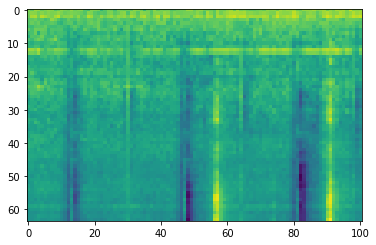

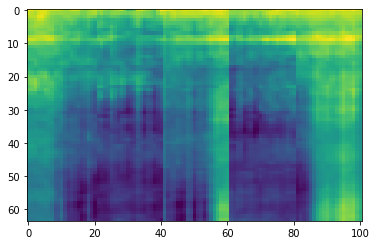

In [6]:
from pytorch_grad_cam import GradCAMPlusPlus

grad_target_layers = [model.ff[4]]
cam = GradCAMPlusPlus(model=model, target_layers=grad_target_layers, use_cuda=True)

# file_name = eval_files[num]
file_name = "/dev/shm/mimii/6dB/valve/id_00/abnormal/00000048.wav"
normal_file_name = "/dev/shm/mimii/6dB/valve/id_02/normal/00000050.wav"


def generate_label(y):
    rms_fig = librosa.feature.rms(y=y)
    rms_tensor = torch.tensor(rms_fig).reshape(1, -1, 1)
    rms_trim = rms_tensor.expand(-1, -1, 512).reshape(1, -1)[:, :160000]

    k = int(y.shape[1]*0.8)
    min_threshold, _ = torch.kthvalue(rms_trim, k)
    label = (rms_trim > min_threshold).type(torch.float)
    label = label.expand(y.shape[0], -1)
    return label

active_label_sources = {}
ys = 0

sr, y = file_to_wav_stereo(file_name)
active_label_sources['id_00'] = generate_label(y)
ys = ys + y
s1 = y[0, :]

sr, y = file_to_wav_stereo(normal_file_name)
active_label_sources['id_02'] = generate_label(y)
ys = ys + y
s2 = y[0, :]

mixture_y = ys

active_labels = torch.stack([active_label_sources[src] for src in ['id_00', 'id_02']])
_, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())

yt = time[0, 0, 0, :].detach().cpu().numpy()
print(yt.shape)
print(mixture_y.shape)
mt = mixture_y[0, :]


data = wav_to_spec_vector_2d_array(sr, yt,
                            n_mels=param["feature"]["n_mels"],
                            frames=param["feature"]["frames"],
                            n_fft=param["feature"]["n_fft"],
                            hop_length=param["feature"]["hop_length"],
                            power=param["feature"]["power"])
data = torch.Tensor(data).cuda()
error1 = torch.mean(((data - model(data)) ** 2), dim=[1, 2])

# max_idx = torch.argmax(error).cpu().item()
# print(torch.max(error))
# print(max_idx)

idx = 160

targets = [ReconOutputTarget(data[idx, :, :])]
cam_result = cam(input_tensor=data[idx:idx + 1, :, :], targets=targets)

spec_list = [data[idx].cpu().numpy().T[:, :]]
cam_list = [1 - cam_result[0, :, :].T]

for i in range (1, 5):
    new_idx = idx + 20 * i
    targets = [ReconOutputTarget(data[new_idx, :, :])]
    cam_result = cam(input_tensor=data[new_idx:new_idx + 1, :, :], targets=targets)

    spec_list.append(data[new_idx].cpu().numpy().T[:, 1:])
    cam_list.append(1 - cam_result[0, 1:, :].T)


plt.imshow(numpy.concatenate(spec_list, axis=1))

plt.figure()

plt.imshow(numpy.concatenate(cam_list, axis=1))



(64, 101)


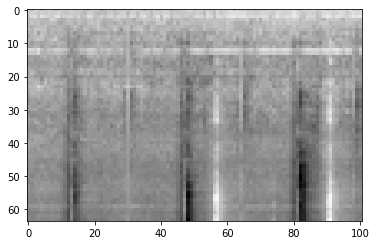

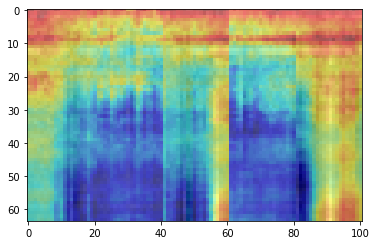

In [7]:
normalize = lambda X : (X - X.min()) / (X.max() - X.min())

spec_image = numpy.concatenate(spec_list, axis=1)
print(spec_image.shape)
spec_image = normalize(spec_image)
spec_image = numpy.repeat(numpy.expand_dims(spec_image, 2), 3, axis=2)

plt.imshow(spec_image)


cam_image = 1 - numpy.concatenate(cam_list, axis=1)

cammed = show_cam_on_image(spec_image, cam_image, use_rgb=False)


plt.figure()

plt.imshow(cammed)